**tradSISOnoCSI**<br>
by $\text{Rishabh Pomaje}$ 

- This file contains the code that simulates Orthogonal Signalling and measures the system performance.
- The results are meant to be used as benchmarks for the DNN learnt in the file $\color{red}{deepSISOnoCSI.ipynb}$
- Two streams are considered, one with channel coding and one without. For the one with channel coding two methods are explored for decoding, *Syndrome decoding (Hard-binary)* and *Maximum Likelihood Decoding (MLD)*

In [2]:
# Dependencies :
import numpy as np 
import scipy as sp
import itertools
import matplotlib.pyplot as plt 
%config InlineBackend.figure_format='svg'

> Function definitions

In [3]:
# Importing from custom made module : CommSysLib
import CommSysLib as csl

- Some definitions :
\begin{equation}
    \text{SNR}_{linear} = \text{Signal-to-noise power ratio per symbol time} = \frac{E_b}{2N_0}
\end{equation}
Consider,
\begin{equation*}
    \frac{1}{2 \times SNR_{linear}} = \frac{1 \times 2N_0}{2 \times E_b} = \frac{N_0}{a} = N_0 \;\dots (a = 1) 
\end{equation*}

\begin{equation*}
    \frac{1}{2 \times R \times SNR_{linear}} = \frac{1 \times n \times 2N_0}{2 \times k \times E_b} = \frac{nN_0}{ka} = nN_0/k \;\dots (a = 1)
\end{equation*}

System Defintions and Parameters

In [4]:
# Uncoded Block length (k) and codeword length (n):
k = 4 
n = 7 
# Information rate (R) :
R = k / n 
# Signal-to-noise ratio range in dB scale and linear scale respectively :
n_points = 30
SNR_dB = np.linspace(-2, 20, n_points)
SNR_lin = 10 ** (SNR_dB / 10)
# Energy available per bit (fixed) -- we will vary the noise accordingly 
E_b = 1 
# AWGN noise variance : this is total (I + Q) noise
noise_var =  1 / (2 * 1 * SNR_lin) # For uncoded
noise_var_c =  1 / (2 * R * SNR_lin) # For coded
# Fading model (Rayleigh) parameters : Only real or imag component
fade_mean = 0
fade_std = np.sqrt(0.5)

Generating the data

In [5]:
n_bits = 4 * (10 ** 6)          # Number of total bits prior to coding
n_bits_c = n_bits * n // k      # Number of total bits after coding
binary_stream_tx = np.random.randint(0, 2, n_bits)

print(f'Samples = {binary_stream_tx[:10]}')

Samples = [1 0 1 1 0 1 0 1 0 0]


> No channel coding pipeline

Performing the Orthogonal Signalling 

In [6]:
signal_stream_tx = csl.pulse_pos_modulation(binary_stream_tx, E_b)

print(f'Samples = {signal_stream_tx[:20]}')

Samples = [0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0.]


Simulating the channel and decoding

In [7]:
BLER_uncoded_ortho = []
count = 0 
for noise in noise_var:
    # Fading 
    fade_taps = np.random.normal(fade_mean, fade_std, n_bits*2) + 1j * np.random.normal(fade_mean, fade_std, n_bits*2)
    signal_stream_rx = fade_taps * signal_stream_tx
    # Noise
    noise_samples = np.random.normal(0, np.sqrt(noise/2), n_bits*2) + 1j * np.random.normal(0, np.sqrt(noise/2), n_bits*2)
    signal_stream_rx = signal_stream_rx + noise_samples
    # Detection 
    binary_stream_rx = csl.square_law_detector(signal_stream_rx)
    # Analysis 
    n_errors, BLER = csl.calcBLER(binary_stream_tx, binary_stream_rx, k)
    BLER_uncoded_ortho.append(BLER)
    # Progress update 
    count = count + 1 
    print(f'Progress : {100 * count // n_points} %', end='\r')

In [8]:
# # Since the theoretical expression is known in closed form I will use that to save time.
# BLER_uncoded = [1 / (2 + 2 * SNR)  for SNR in SNR_lin]

# plt.semilogy(SNR_dB, BLER_uncoded_ortho, label='mine')
# plt.semilogy(SNR_dB, BLER_uncoded, label='theoretical')
# plt.legend()

> Channel Coding Enabled Pipeline

In [9]:
# Generator matrix for (7, 4) Hamming Code :
G = np.array(
    [
        [1, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 1, 0, 1],
        [0, 0, 1, 0, 0, 1, 1],
        [0, 0, 0, 1, 1, 1, 1]
    ], dtype=int)
# Parity Check Matrix for (7, 4) Hamming Code :
H = np.array([
    [1, 1, 0, 1, 1, 0, 0],
    [1, 0, 1, 1, 0, 1, 0],
    [0, 1, 1, 1, 0, 0, 1]
    ], dtype=int)

Performing the channel coding 

In [10]:
channel_coded_stream_tx = csl.hamming_encoder(binary_stream_tx, G)
print(f'Samples = {channel_coded_stream_tx[:10]}')

Samples = [1 0 1 1 0 1 0 0 1 0]


Performing the Orthogonal Signalling

In [11]:
signal_stream_tx = csl.pulse_pos_modulation(channel_coded_stream_tx, E_b)
print(f'Samples = {signal_stream_tx[:20]}')

Samples = [0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0.]


In [12]:
print(np.linalg.norm(signal_stream_tx) ** 2)

6999999.999999999


Simulating the channel and the receiver 
- Hard Decoding + Syndrome-based correction   

In [13]:
BLER_coded_ortho_hard = []
count = 0 
for noise in noise_var_c:
    # Fading 
    fade_taps = np.random.normal(fade_mean, fade_std, n_bits_c*2) + 1j * np.random.normal(fade_mean, fade_std, n_bits_c*2)
    signal_stream_rx = fade_taps * signal_stream_tx    
    # Noise
    noise_samples = np.random.normal(0, np.sqrt(noise/2), n_bits_c*2) + 1j * np.random.normal(0, np.sqrt(noise/2), n_bits_c*2) 
    signal_stream_rx = signal_stream_rx + noise_samples 
    # Decoding 
    binary_coded_stream_rx = csl.square_law_detector(signal_stream_rx)
    # Correction 
    binary_stream_rx = csl.hamming_decoder(binary_coded_stream_rx, H)
    # Analysis 
    n_errors, BLER = csl.calcBLER(binary_stream_tx, binary_stream_rx, k)
    BLER_coded_ortho_hard.append(BLER)
    # Update the progress 
    count = count + 1 
    print(f'Progress : {100 * count // n_points} %', end='\r') 

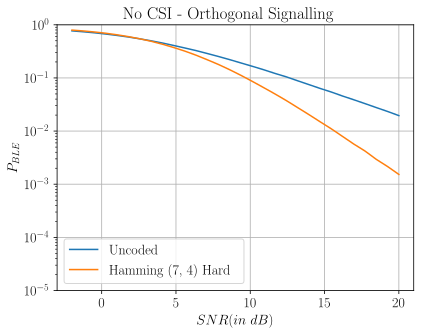

In [14]:
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 14,
    "font.family" : 'Serif'
})
fig, axes = plt.subplots()
axes.semilogy(SNR_dB, BLER_uncoded_ortho, label='Uncoded')
axes.semilogy(SNR_dB, BLER_coded_ortho_hard, label='Hamming (7, 4) Hard')
# Markings 
axes.set_xlabel(r'$SNR (in\ dB)$')
axes.set_ylabel(r'$P_{BLE}$')
axes.set_ylim(10**-5,10**0)
axes.set_xlim(-3, 21)
axes.legend()
axes.set_title(f'No CSI - Orthogonal Signalling')
axes.grid(True, which="major")

In [16]:
# Saving the figure for future reference 
fig.savefig("plots/tradSISOnoCSI.svg", transparent=True)
with open(file="results/tradSISOnoCSI.txt", mode='w') as file_id:
    file_id.write(f'BLER_uncoded_ortho = {BLER_uncoded_ortho}\n')
    file_id.write(f'BLER_coded_ortho_hard = {BLER_coded_ortho_hard}')

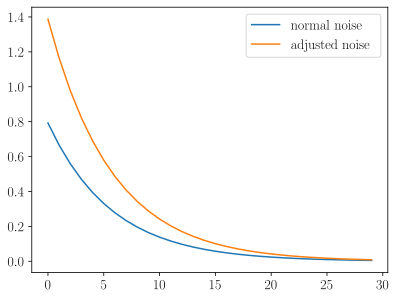

In [20]:
plt.plot(noise_var, label='normal_noise')
plt.plot(noise_var_c, label='adjusted noise')
plt.legend()